In [1]:
import os
import pandas as pd
import numpy as np
from minisom import MiniSom
import matplotlib.pyplot as plt
import seaborn as sns


# Load Data
df = pd.read_csv('data/feature_engineered.csv.gz', compression='gzip')
# df = pd.read_csv('data/dummied.csv.gz', compression='gzip')

exclude = ['account_id', 'is_current_customer', 'is_self_service', 'country', 'state', 'country_top', 'state_top', 'industry_grouped', 'company_revenue_bucket', 'dnb_founded_time_grouped']

df['account_id'] = df['account_id'].astype('object')

float64_columns = df.select_dtypes(include='float64').columns
int64_columns = df.select_dtypes(include='int64').columns
bool_columns = df.select_dtypes(include='bool').columns


In [2]:
selected = df.drop(exclude, axis=1)

# Convert boolean columns to integers
bool_columns = selected.select_dtypes(include=bool).columns
selected[bool_columns] = selected[bool_columns].astype(int)

# Define MiniSom parameters
input_len = len(selected.columns)
x, y = 5, 5  # Adjust the grid size as needed

# Initialize MiniSom
som = MiniSom(x, y, input_len, sigma=1.0, learning_rate=0.5)

# Train MiniSom
som.train(selected.values, 1000, random_order=True, verbose=True)

# Find the BMU for each input vector where 'is_arr_over_12k' is True
arr_over_12k_mask = selected['is_arr_over_12k'] == 1
bmus_true_class = np.array([som.winner(x) for x in selected[arr_over_12k_mask].values])
bmus = np.array([som.winner(x) for x in selected.values])

# Add BMUs to the DataFrame
df['bmu_x'] = bmus[:, 0]
df['bmu_y'] = bmus[:, 1]

# Calculate the center of the 'is_arr_over_12k' = True group
center_of_true_class = np.mean(som.get_weights()[bmus_true_class[:, 0], bmus_true_class[:, 1]], axis=0)

# Calculate Euclidean distance of each row to the center of the 'is_arr_over_12k' = True group
distances_to_center = np.linalg.norm(selected.values - center_of_true_class, axis=1)

# Create a new column based on distances
df['som_distance'] = distances_to_center

# Display the result
display(df[['account_id', 'is_arr_over_12k', 'som_distance']])


 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 6.725334128279707


,account_id,is_arr_over_12k,som_distance
0,001PY000002SuJDYA0,0,2.285069
1,0011G00000nEkzYQAS,0,1.735647
2,0011G00000qFM5EQAW,0,1.840955
3,0011G00000tKtSbQAK,0,1.669950
4,0011G00000tLivvQAC,0,2.073923
...,...,...,...
509594,0011G00000f7hy5QAA,0,18.445095
509595,0011G00000gY2yjQAC,0,20.793592
509596,0011G00000mULinQAG,0,22.703192
509597,0011G00000hC4rZQAS,0,22.110602


In [3]:
# Assign each row to the cluster represented by the BMU
df['cluster'] = [f'{i}-{j}' for i, j in bmus]

# One-hot encode the cluster column with a different name
df = pd.concat([df, pd.get_dummies(df['cluster'], prefix='cluster_', drop_first=True)], axis=1)

# Add columns indicating the X and Y coordinates of the winning neuron for each row
df['neuron_x'] = bmus[:, 0]
df['neuron_y'] = bmus[:, 1]

# Count how many times each neuron wins (BMU) during training
neuron_activation_frequency = pd.DataFrame(bmus, columns=['neuron_x', 'neuron_y']).groupby(['neuron_x', 'neuron_y']).size().reset_index(name='activation_frequency')

# Merge the activation frequency with the main DataFrame
df = pd.merge(df, neuron_activation_frequency, on=['neuron_x', 'neuron_y'], how='left')
df['activation_frequency'].fillna(0, inplace=True)


# Calculate activation distance for each row
activation_distances = np.linalg.norm(selected.values - som.get_weights()[bmus[:, 0], bmus[:, 1]], axis=1)

# Add activation distance to the DataFrame
df['activation_distance'] = activation_distances
df['activation_distance'] = df['activation_distance'].fillna(0)


In [4]:
df.head()

,account_id,is_current_customer,is_self_service,is_arr_over_12k,company_revenue_bucket,country,state,industry_grouped,has_crossbeam_data,crossbeam_product1_customer,...,cluster__3-4,cluster__4-0,cluster__4-1,cluster__4-2,cluster__4-3,cluster__4-4,neuron_x,neuron_y,activation_frequency,activation_distance
0,001PY000002SuJDYA0,False,0,0,Under 10B,CH,NaN,9. Other,False,0,...,False,False,False,False,False,False,1,3,26167,1.532267
1,0011G00000nEkzYQAS,False,0,0,NaN,NL,NaN,9. Other,False,0,...,False,False,False,False,False,False,0,0,24237,1.145882
2,0011G00000qFM5EQAW,False,0,0,NaN,NaN,NaN,NaN,False,0,...,False,True,False,False,False,False,4,0,32512,0.012378
3,0011G00000tKtSbQAK,False,0,0,NaN,RO,NaN,9. Other,False,0,...,False,False,False,False,False,False,1,0,20599,0.066184
4,0011G00000tLivvQAC,False,0,0,NaN,IN,NaN,3. Finance,False,0,...,False,False,False,False,False,False,1,2,18030,1.477305


In [5]:

# Save the results
df.to_csv('data/organized.csv.gz', compression='gzip', index=False)


In [6]:
# Describe when is_arr_over_12k is True
print("ARR > $12k")
print(df[df['is_arr_over_12k'] == 1]['som_distance'].describe())

# Describe when is_arr_over_12k is False
print("ARR < $12k")
print(df[df['is_arr_over_12k'] == 0]['som_distance'].describe())

ARR > $12k
count    3417.000000
mean       16.273800
std         3.844522
min         1.616908
25%        14.059996
50%        14.794084
75%        18.918238
max        25.567231
Name: som_distance, dtype: float64
ARR < $12k
count    500720.000000
mean          7.179668
std           7.407228
min           1.146624
25%           1.653348
50%           1.859482
75%          14.764895
max          25.561508
Name: som_distance, dtype: float64


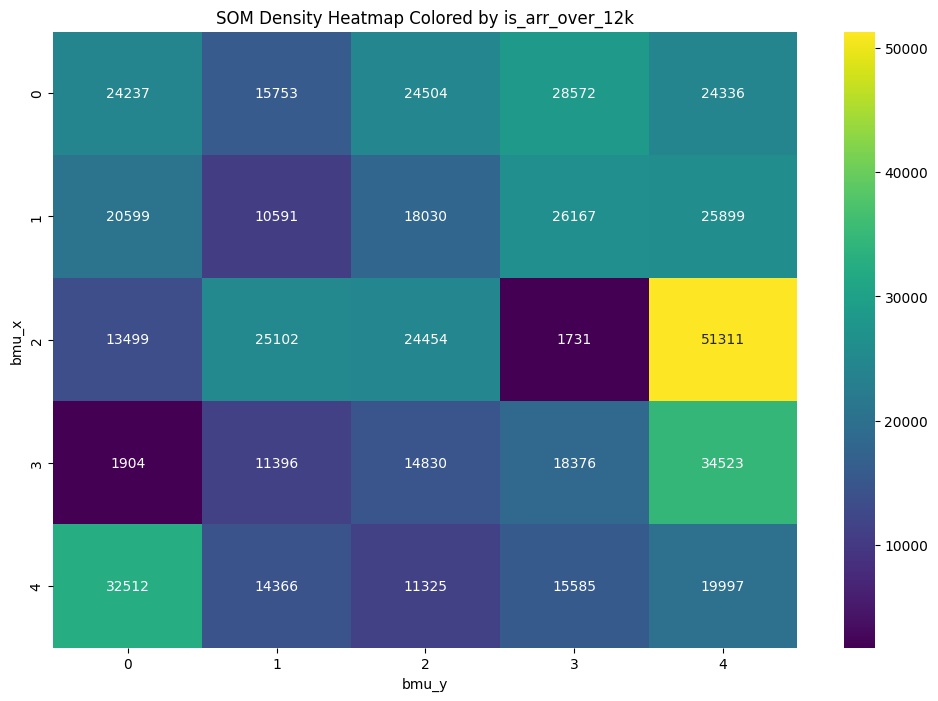

In [7]:
# Scatterplot of bmu_x and bmu_y, colored by 'is_arr_over_12k'
plt.figure(figsize=(12, 8))
sns.heatmap(df.pivot_table(index='bmu_x', columns='bmu_y', values='is_arr_over_12k', aggfunc='count', fill_value=0), cmap='viridis', annot=True, fmt='g')
plt.title('SOM Density Heatmap Colored by is_arr_over_12k')

plt.show()

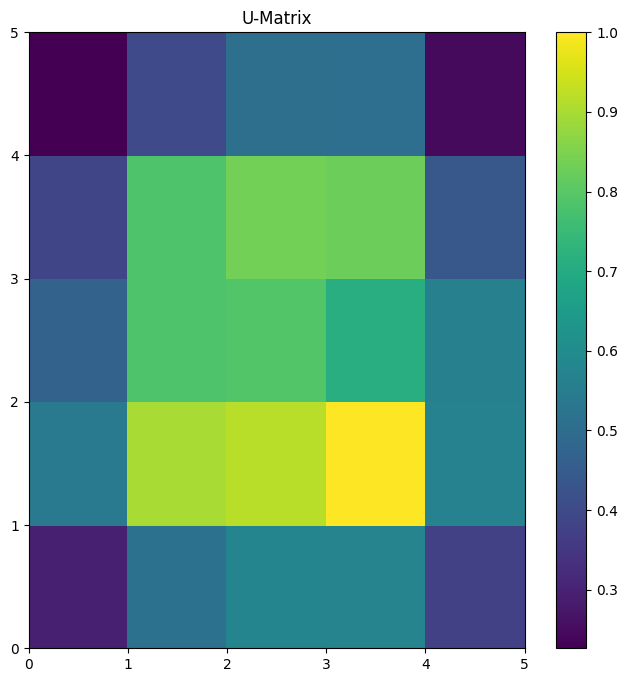

In [8]:
# Calculate the U-Matrix
u_matrix = som.distance_map()

# Plot the U-Matrix
plt.figure(figsize=(8, 8))
plt.pcolor(u_matrix, cmap='viridis')  # Use a colormap of your choice
plt.colorbar()

plt.title('U-Matrix')
plt.show()

/Users/christopher/Library/CloudStorage/Dropbox/Code/five_twelve/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


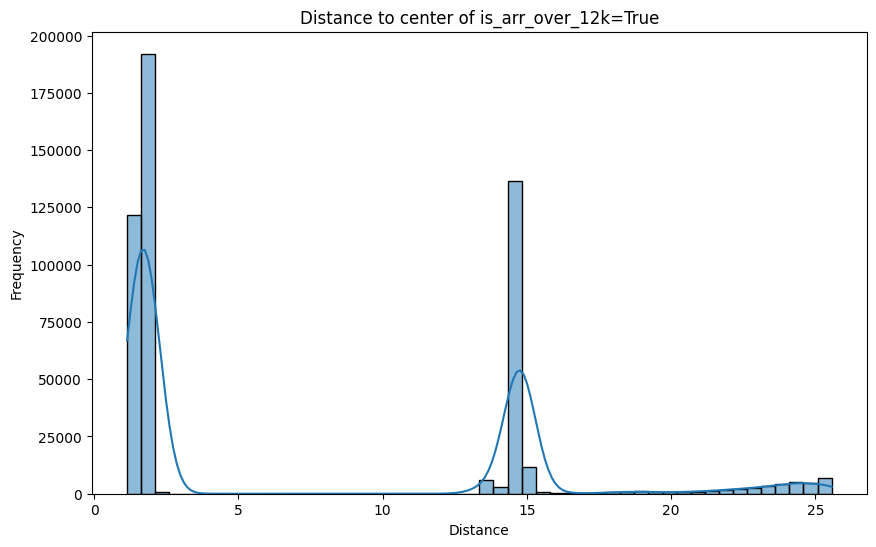

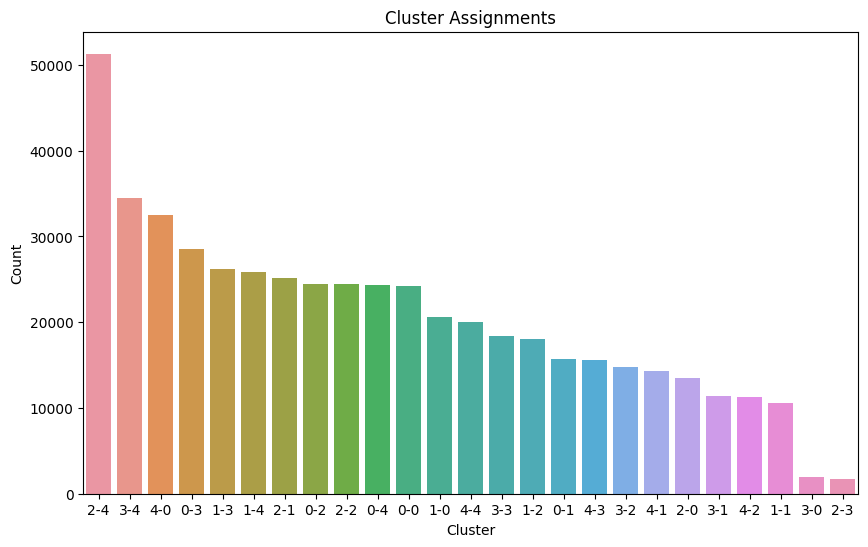

/Users/christopher/Library/CloudStorage/Dropbox/Code/five_twelve/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


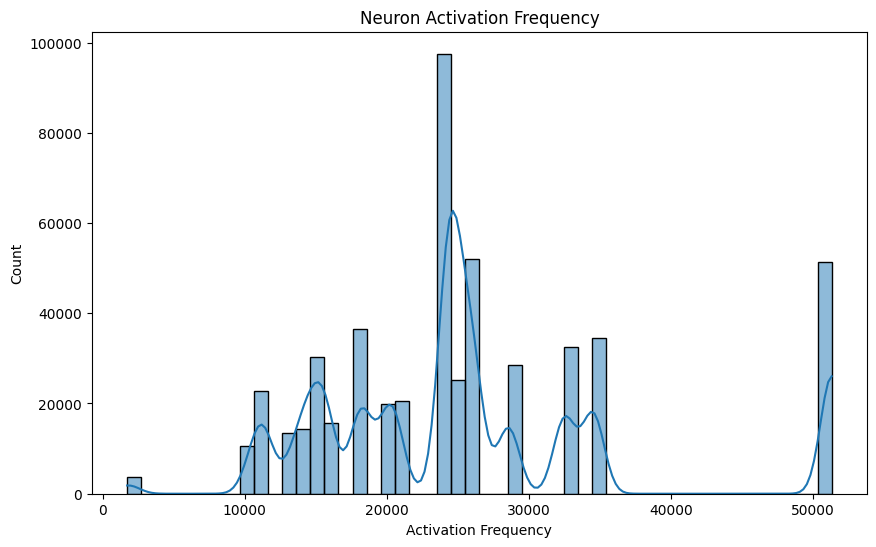

/Users/christopher/Library/CloudStorage/Dropbox/Code/five_twelve/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


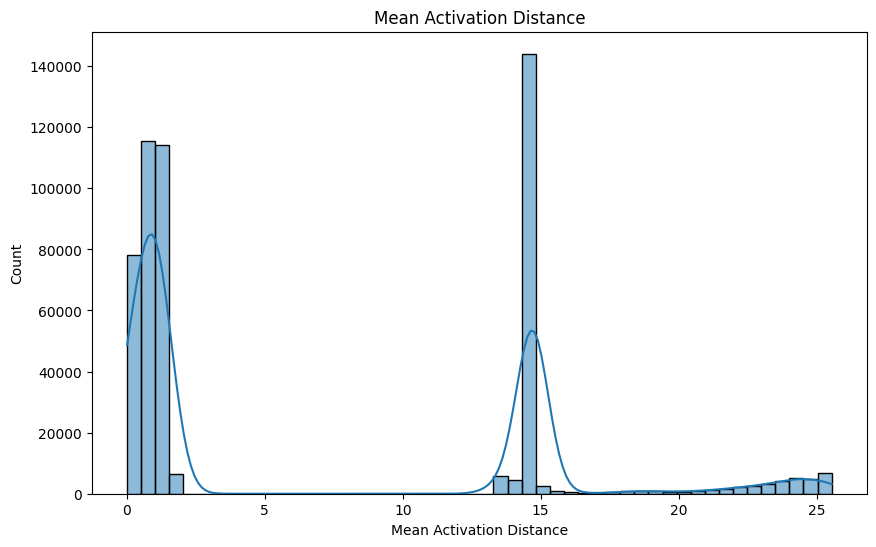

In [9]:

# Visualize Distance to Nearest Row with is_arr_over_12k=True
plt.figure(figsize=(10, 6))
sns.histplot(df['som_distance'], bins=50, kde=True)
plt.title('Distance to center of is_arr_over_12k=True')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

# Visualize Cluster Assignments
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=df, order=df['cluster'].value_counts().index)
plt.title('Cluster Assignments')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

# Visualize Neuron Activation Frequency
plt.figure(figsize=(10, 6))
sns.histplot(df['activation_frequency'], bins=50, kde=True)
plt.title('Neuron Activation Frequency')
plt.xlabel('Activation Frequency')
plt.ylabel('Count')
plt.show()

# Visualize Mean Activation Distance
plt.figure(figsize=(10, 6))
sns.histplot(df['activation_distance'], bins=50, kde=True)
plt.title('Mean Activation Distance')
plt.xlabel('Mean Activation Distance')
plt.ylabel('Count')
plt.show()


/Users/christopher/Library/CloudStorage/Dropbox/Code/five_twelve/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


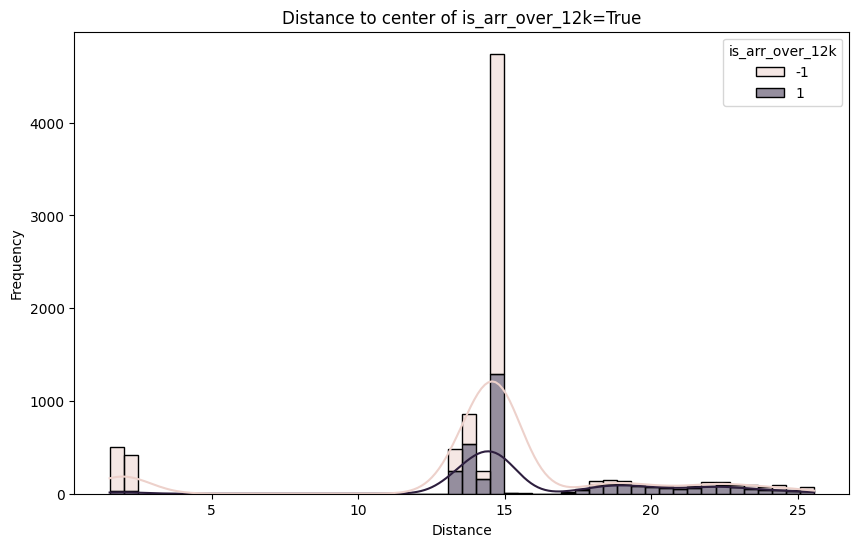

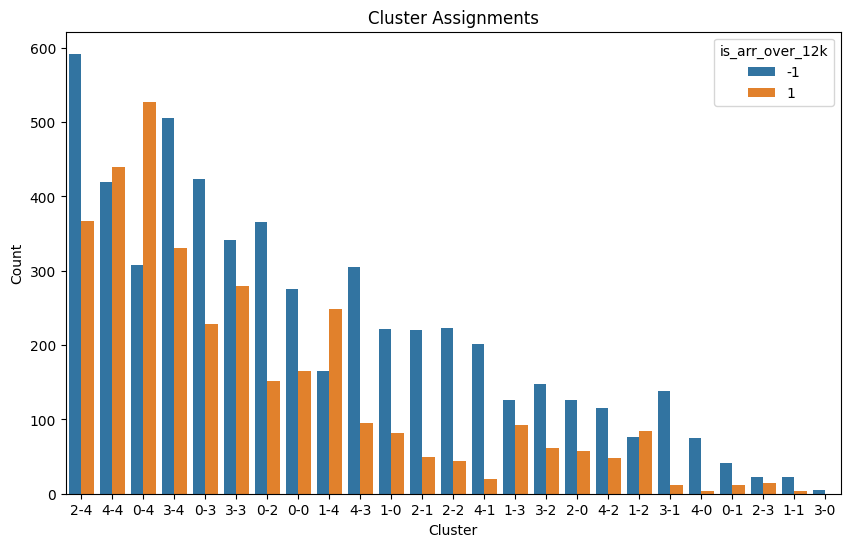

/Users/christopher/Library/CloudStorage/Dropbox/Code/five_twelve/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


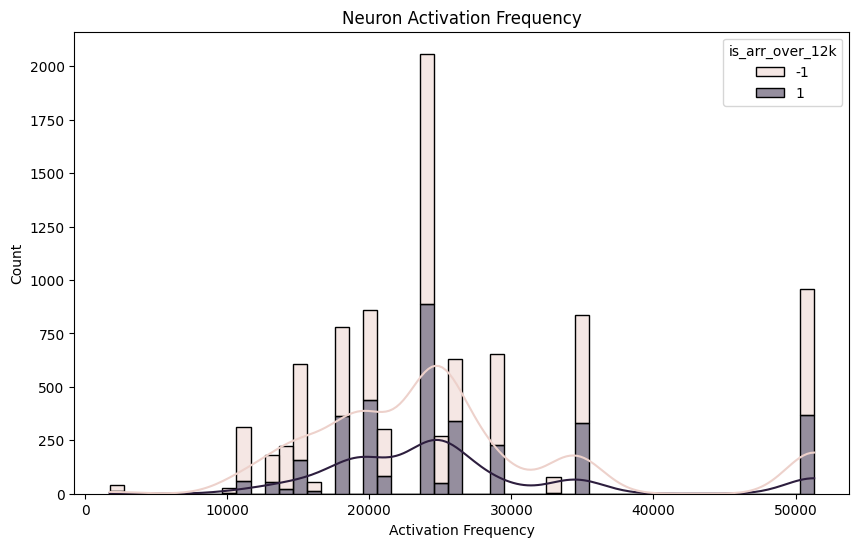

/Users/christopher/Library/CloudStorage/Dropbox/Code/five_twelve/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


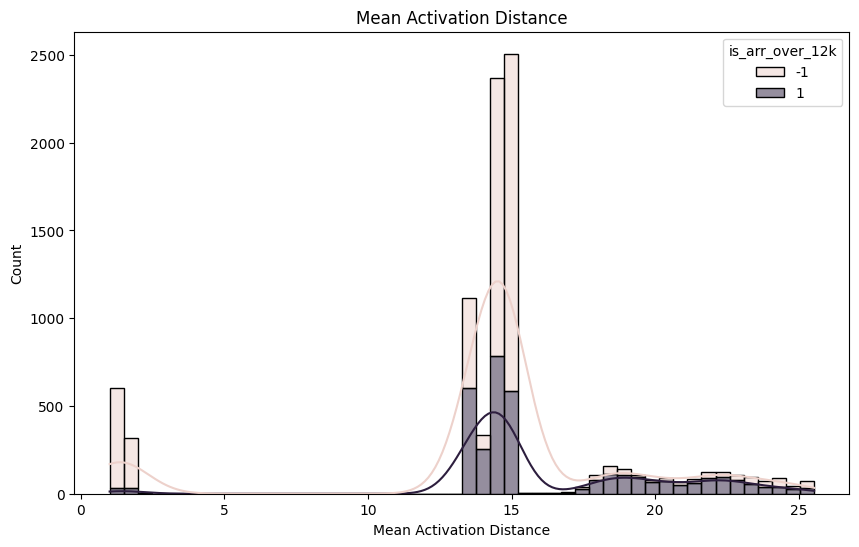

In [10]:
# Filter out missing values
df_filtered = df_filtered = df[df['is_arr_over_12k'] != 0]

# Visualize Distance to Nearest Row with is_arr_over_12k=True
plt.figure(figsize=(10, 6))
sns.histplot(data=df_filtered, x='som_distance', bins=50, kde=True, hue='is_arr_over_12k', multiple='stack')
plt.title('Distance to center of is_arr_over_12k=True')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

# Visualize Cluster Assignments
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=df_filtered, order=df_filtered['cluster'].value_counts().index, hue='is_arr_over_12k')
plt.title('Cluster Assignments')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

# Visualize Neuron Activation Frequency
plt.figure(figsize=(10, 6))
sns.histplot(data=df_filtered, x='activation_frequency', bins=50, kde=True, hue='is_arr_over_12k', multiple='stack')
plt.title('Neuron Activation Frequency')
plt.xlabel('Activation Frequency')
plt.ylabel('Count')
plt.show()

# Visualize Mean Activation Distance
plt.figure(figsize=(10, 6))
sns.histplot(data=df_filtered, x='activation_distance', bins=50, kde=True, hue='is_arr_over_12k', multiple='stack')
plt.title('Mean Activation Distance')
plt.xlabel('Mean Activation Distance')
plt.ylabel('Count')
plt.show()